In [1]:
#Imports
import numpy as np
import math
import sys
import random
import time
import os
import threading
%matplotlib inline
import matplotlib.pyplot as plt
#from sklearn.metrics import r2_score
#from sklearn.cross_validation import train_test_split
#from sklearn.model_selection import train_test_split
nuc_arr = ['A','C','G','T']
#Function for calculating modified probability of splicing at SD1
def prob_SD1 (sd1_freq, sd2_freq):
    if (sd1_freq==0 and sd2_freq==0):
        return 0.0
    else:
        return sd1_freq/(sd1_freq+sd2_freq)
#Function converting nucleotide sequence to numerical array with 4 channels
def seq_to_arr (seq):
    seq_len = len(seq)
    arr_rep = np.zeros((seq_len, len(nuc_arr)))
    for i in range(seq_len):
        arr_rep[i][nuc_arr.index(seq[i])] = 1
    return arr_rep
#Creating a modified dataset with only the necessary information
#Storing model inputs and outputs
dataset_path = os.path.expanduser("~/5SS_compressed.txt")
seq_len = 101
n = 265137
all_seq = []
inputs = np.zeros((n,seq_len, 4))
prob_s1 = np.zeros(n)
with open(dataset_path) as f:
    ind = 0
    for line in f:
        mod_line = line.split('\t')
        all_seq.append(mod_line[1])
        inputs[ind] = seq_to_arr(mod_line[1])
        prob_s1[ind] = prob_SD1(float(mod_line[2]), float(mod_line[3][:-1]))
        ind += 1

#print(all_seq[0])
#print(len(all_seq))

#Hamming Distance Computation Function
def num_mismatches(seq1, seq2):
    return sum(a!=b for a, b in zip(seq1, seq2))


In [2]:
#Loading CNP Indices - MaxVar with all context attached, Rand with random context
maxvar_ind = np.load("/home/unagpal/CNPDataIndMaxVarExp1.npy")
rand_ind = np.load("/home/unagpal/CNPDataIndRandExp1.npy")
all_distance_rand = np.zeros(len(rand_ind)-100)
all_distance_maxvar = np.zeros(len(maxvar_ind)-100)
#Loading CNN Indices
bald_ind = np.load("/home/unagpal/BaldIndicesExp1.npy")
rand_cnn_ind = np.load("/home/unagpal/RandIndicesExp1.npy")
all_distance_rand_cnn = np.zeros(len(rand_cnn_ind)-100)
all_distance_bald = np.zeros(len(bald_ind)-100)

In [3]:
#Getting average CNP Hamming distance to current training set of each acquired point
for i in range(0, len(rand_ind)-100):
    total_mismatches_rand = 0
    total_mismatches_maxvar = 0
    for j in range(0, i+100):
        total_mismatches_rand += num_mismatches(all_seq[rand_ind[i+100]], all_seq[rand_ind[j]])
        total_mismatches_maxvar += num_mismatches(all_seq[maxvar_ind[i+100]], all_seq[maxvar_ind[j]])
    all_distance_rand[i] = total_mismatches_rand/(i+100)
    all_distance_maxvar[i] = total_mismatches_maxvar/(i+100)

In [5]:
#Getting average CNP Hamming distance of acquired points to entire 265137-point training set
all_overall_distance_rand = np.zeros(len(rand_ind)-100)
all_overall_distance_maxvar = np.zeros(len(rand_ind)-100)
for i in range(0, len(rand_ind)-100):
    total_mismatches_rand = 0
    total_mismatches_maxvar = 0
    all_indices_rand = list(range(n))
    all_indices_maxvar = list(range(n))
    del all_indices_rand[rand_ind[i+100]]
    del all_indices_maxvar[maxvar_ind[i+100]]
    rand_sample_ind = np.random.choice(all_indices_rand, 1000, replace=False)
    maxvar_sample_ind = np.random.choice(all_indices_maxvar, 1000, replace=False)
    for j in rand_sample_ind:
        total_mismatches_rand += num_mismatches(all_seq[rand_ind[i+100]], all_seq[j])
    for k in maxvar_sample_ind:
        total_mismatches_maxvar += num_mismatches(all_seq[maxvar_ind[i+100]], all_seq[k])
    all_overall_distance_rand[i] = total_mismatches_rand/(1000)
    all_overall_distance_maxvar[i] = total_mismatches_maxvar/(1000)

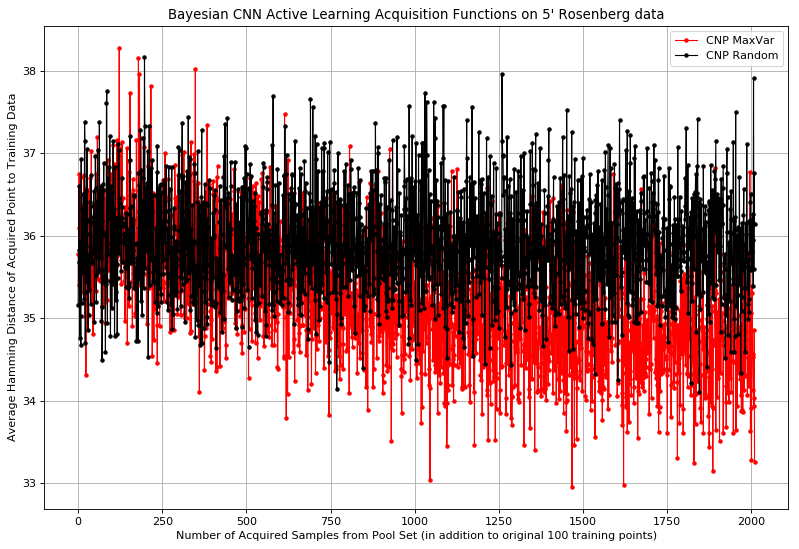

In [6]:
#CNP Hamming distance graph (to current training set)
Queries = np.arange(0, len(all_distance_rand), 1)
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(Queries, all_distance_maxvar, color="red", linewidth=1.0, marker='.', label="CNP MaxVar")
plt.plot(Queries, all_distance_rand, color="black", linewidth=1.0, marker='.', label="CNP Random" )

plt.xlabel("Number of Acquired Samples from Pool Set (in addition to original 100 training points)")
plt.ylabel("Average Hamming Distance of Acquired Point to Training Data")
plt.title("Bayesian CNN Active Learning Acquisition Functions on 5' Rosenberg data")
plt.grid()

plt.legend(loc = 1)
plt.show()

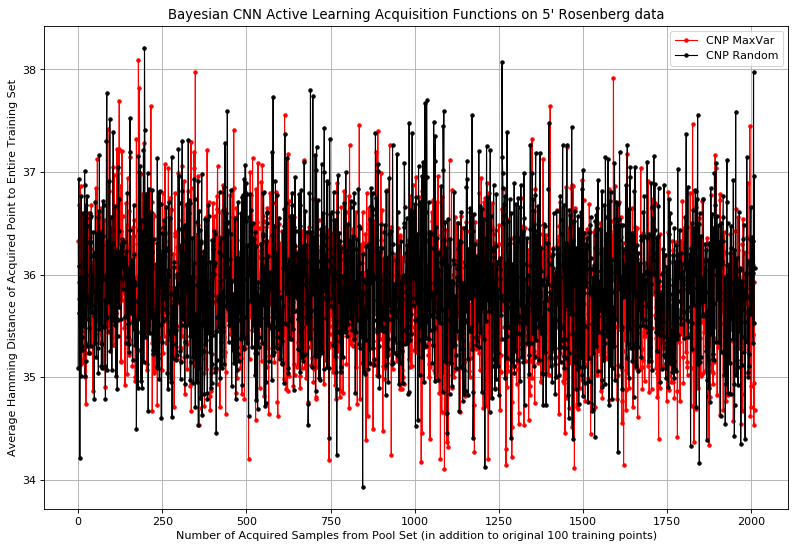

In [7]:
#CNP Hamming distance graph (to ENTIRE training set)
Queries = np.arange(0, len(all_distance_rand), 1)
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(Queries, all_overall_distance_maxvar, color="red", linewidth=1.0, marker='.', label="CNP MaxVar")
plt.plot(Queries, all_overall_distance_rand, color="black", linewidth=1.0, marker='.', label="CNP Random" )

plt.xlabel("Number of Acquired Samples from Pool Set (in addition to original 100 training points)")
plt.ylabel("Average Hamming Distance of Acquired Point to Entire Training Set")
plt.title("Bayesian CNN Active Learning Acquisition Functions on 5' Rosenberg data")
plt.grid()

plt.legend(loc = 1)
plt.show()

In [8]:
#Getting average CNN Hamming distance to current training set of each acquired point
for i in range(0, len(all_distance_rand_cnn)):
    total_mismatches_rand = 0
    total_mismatches_bald = 0
    for j in range(0, i+100):
        total_mismatches_rand += num_mismatches(all_seq[rand_cnn_ind[i+100]], all_seq[rand_cnn_ind[j]])
        total_mismatches_bald += num_mismatches(all_seq[bald_ind[i+100]], all_seq[bald_ind[j]])
    all_distance_rand_cnn[i] = total_mismatches_rand/(i+100)
    all_distance_bald[i] = total_mismatches_bald/(i+100)

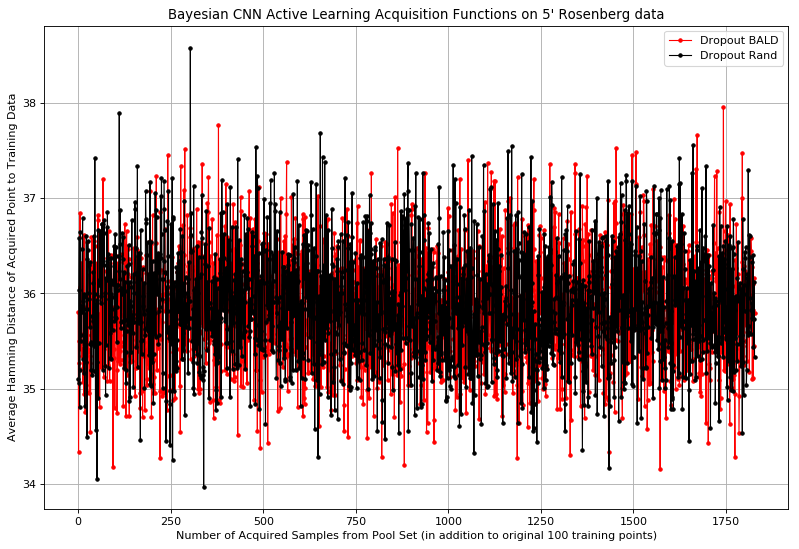

In [9]:
#CNN Hamming distance graph
Queries = np.arange(0, len(all_distance_rand_cnn), 1)
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(Queries, all_distance_bald, color="red", linewidth=1.0, marker='.', label="Dropout BALD")
plt.plot(Queries, all_distance_rand_cnn, color="black", linewidth=1.0, marker='.', label="Dropout Rand" )

plt.xlabel("Number of Acquired Samples from Pool Set (in addition to original 100 training points)")
plt.ylabel("Average Hamming Distance of Acquired Point to Training Data")
plt.title("Bayesian CNN Active Learning Acquisition Functions on 5' Rosenberg data")
plt.grid()

plt.legend(loc = 1)
plt.show()